# #Multifiber

In [1]:
%load_ext autoreload
%autoreload 2
import sys
codebase_dir = '/Users/juan/ZiaLab/Codebase'
sys.path.append(codebase_dir)
import wavesight as ws
import numpy as np
from matplotlib import pyplot as plt
import h5py
import pandas as pd

This notebook shows how the modes of a step-index fiber are calculated. This is a simple task that involves solving the roots of a trascendental equation. There is some nuance in how to solve for all the zeros, since some of them start getting increasingly close, but the task is fundamentally simple.

## ## Theoretical Background

<center> <img src="notebook_imgs/multisolver.jpeg" style="width: 100%;"/> </center>

<center> <img src="notebook_imgs/2023-08-01-17-04-00.png" style="width: 100%;"/> </center>

<center> <img src="notebook_imgs/2023-08-01-17-04-18.png" style="width: 100%;"/> </center>

<center> <img src="notebook_imgs/2023-08-01-17-04-33.png" style="width: 100%;"/> </center>

<center> <img src="notebook_imgs/2023-08-01-17-04-48.png" style="width: 100%;"/> </center>

## ## multisolver

### ###FG050LGA

The FG050LGA is a multimode fiber with the following characteristics:

* Core diameter (50 ± 1) μm. 
* Cladding diameter (125 +1/-2) μm.
* (0.22 ± 0.02) NA
* Low OH content (probably a few parts per 10⁹)
* Operating wavelengths [400 - 2400] nm
* Core is of pure SiO₂.
* Cladding is fluorine-doped SiO₂.
* At 808 nm its attenuation should at most be 8 dB per km, typical attenueation show in the plot below.
* At 600 nm it has about 1700 propagating modes.

More details [here](https://www.thorlabs.com/thorproduct.cfm?partnumber=FG050LGA).

<center> <img src="notebook_imgs/2023-08-01-10-20-14.png" style="width: 100%;"/> </center>

### ###Calculate the allowed propagation constants kz

In [2]:
fiber_spec = {'NA': 0.5,
              'nCore': 1.45,
              'coreRadius':10.,
              'grid_divider': 2,
              'nFree': 1.,
              'λFree': 0.600}
fiber_sol = ws.multisolver(fiber_spec,
                           solve_modes = 'all',
                           drawPlots=False,
                           verbose=True)

Estimating nCladding from nCore and NA ...
Approx number of complex HE modes:  659
Approx number of TE modes:  26
Approx number of TM modes:  26
Approx number of total modes:  1370
Approx Max n for HE modes:  36
Calculating TM(0,n) propagation constants ...
Calculating TE(0,n) propagation constants ...
Calculating HE(m,n) propagation constants ...
m=48
HE modes = 1356
TE modes = 16
TM modes = 16
TOTAL modes = 1388
FROM_Vnum = 1370


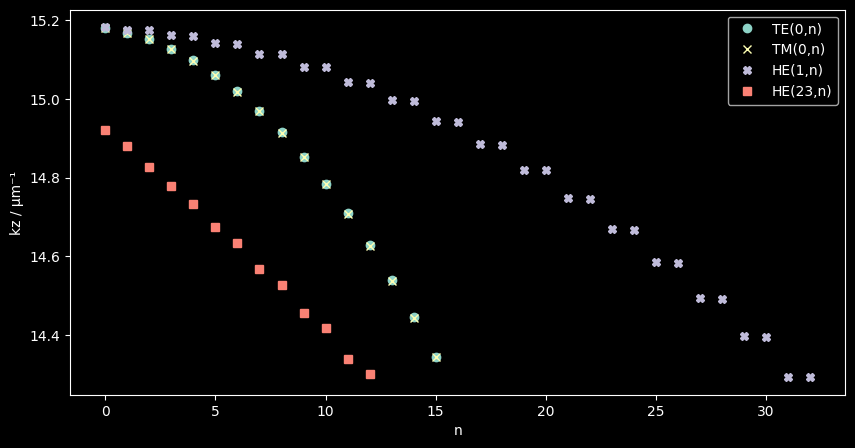

In [3]:
plt.figure(figsize=(10, 5))
plt.plot(fiber_sol['TEkz'][0], 'o', label='TE(0,n)')
plt.plot(fiber_sol['TMkz'][0], 'x', label='TM(0,n)')
keys = list(fiber_sol['HEkz'].keys())
if len(keys):
    plt.plot(fiber_sol['HEkz'][keys[0]], 'X', label='HE(1,n)')
    middle_key = int(len(keys)/2)
    plt.plot(fiber_sol['HEkz'][keys[middle_key]], 's', label='HE(%d,n)' % middle_key)
plt.xlabel('n')
plt.ylabel('kz / μm⁻¹')
plt.legend()
plt.show()

### ###Calculate the numerical mode basis

The propagation constants determine the corresponding fields. If numerical approximations to these modes are to be used frequently, a function that calculates a numerical approximation for all the modes might prove useful unless memory constraints become an issue. The function `calculate_numerica_basis` does precisely that.

In [130]:
?ws.calculate_numerical_basis

Signature: ws.calculate_numerical_basis(fiber_sol, verbose=True)
Docstring:
Given a solution for the propagation modes of an optical waveguide, calculate a numerical basis.

Parameters
----------
fiber_sol : dict
    A dictionary containing the fiber solution. It needs to have
    the following keys:
    - 'coreRadius' : float
        The radius of the core.
    - 'nCladding' : float
        The refractive index of the cladding.
    - 'nCore' : float
        The refractive index of the core.
    - 'free_space_wavelength' : float
        The wavelength of the light in free space.
    - 'totalModes' : int
        The total number of calculated modes.
    - 'TEkz' : 1D dict
        A single key equal to m=0, the values are array with
        the TE modes propagation constants.
    - 'TMkz' : 1D dict
        A single key equal to m=0, the values are array with
        the TM modes propagation constants.
    - 'HEkz' : 1D dict
        Keys are m values, values are 1D arrays of kz values.

R

In [141]:
fiber_sol = ws.calculate_numerical_basis(fiber_sol)

/Users/juan/ZiaLab/Codebase/wavesight/fieldgenesis.py:713: RuntimeWarning: invalid value encountered in add
  return -0.5*(a*np.sqrt(-kz**2 + kFree**2*nCore**2)*(special.kn(-1 + m,(np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))*ρ)/a)*(-1 - (2*kFree**2*m*(nCladding**2 - nCore**2)*special.jv(m,a*np.sqrt(-kz**2 + kFree**2*nCore**2))*special.kn(m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))))/(a*(kz**2 - kFree**2*nCladding**2)*np.sqrt(-kz**2 + kFree**2*nCore**2)*(special.jv(-1 + m,a*np.sqrt(-kz**2 + kFree**2*nCore**2)) - special.jv(1 + m,a*np.sqrt(-kz**2 + kFree**2*nCore**2)))*special.kn(m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))) + np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))*(kz**2 - kFree**2*nCore**2)*special.jv(m,a*np.sqrt(-kz**2 + kFree**2*nCore**2))*(special.kn(-1 + m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))) + special.kn(1 + m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2)))))) + (1 - (2*kFree**2*m*(nCladding**2 - nCore**2)*special.jv(m,a*np.sqrt(-kz**2 + kFree**2*nCore**2)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

/Users/juan/ZiaLab/Codebase/wavesight/fieldgenesis.py:713: RuntimeWarning: invalid value encountered in scalar add
  return -0.5*(a*np.sqrt(-kz**2 + kFree**2*nCore**2)*(special.kn(-1 + m,(np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))*ρ)/a)*(-1 - (2*kFree**2*m*(nCladding**2 - nCore**2)*special.jv(m,a*np.sqrt(-kz**2 + kFree**2*nCore**2))*special.kn(m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))))/(a*(kz**2 - kFree**2*nCladding**2)*np.sqrt(-kz**2 + kFree**2*nCore**2)*(special.jv(-1 + m,a*np.sqrt(-kz**2 + kFree**2*nCore**2)) - special.jv(1 + m,a*np.sqrt(-kz**2 + kFree**2*nCore**2)))*special.kn(m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))) + np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))*(kz**2 - kFree**2*nCore**2)*special.jv(m,a*np.sqrt(-kz**2 + kFree**2*nCore**2))*(special.kn(-1 + m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))) + special.kn(1 + m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2)))))) + (1 - (2*kFree**2*m*(nCladding**2 - nCore**2)*special.jv(m,a*np.sqrt(-kz**2 + kFree**2*nC

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [142]:
# test all modes for boundary conditions
a = fiber_spec['coreRadius']
kFree = fiber_spec['kFree']
nCladding = fiber_spec['nCladding']
nCore = fiber_spec['nCore']
λFree = 2*np.pi/kFree
allTests = []
for fieldType in ['TM', 'TE', 'HE']:
    allkzs = fiber_sol[fieldType + 'kz']
    for m, kzs in allkzs.items():
        for kzidx, kz in enumerate(kzs):
            Efuncs, Hfuncs = ws.fieldGenerator(a=a, kFree=kFree, kz=kz, m=m, nCladding=nCladding, nCore=nCore, fieldType=fieldType)
            test = ws.boundary_test(Efuncs, Hfuncs, fiber_spec, modeType=fieldType)
            allTests.append((fieldType, m, kzidx, kz, test))
# find all failed tests
failed = list(filter(lambda x: not x[-1][0], allTests))
print("%d/%d failed" % (len(failed), len(allTests)))
for fail in failed:
    print(fail)

OrderedDict([('DCladdingρ', 0.19118422434168833), ('BCladdingρ', -0.14486404837933683), ('ECladdingϕ', 0.09973538109785254), ('ECladdingz', -0.03573462224349107j), ('HCladdingϕ', 0.13160517590225881), ('HCladdingz', 0.05010599095314941j)]) OrderedDict([('DCoreρ', 0.19118743128856705), ('BCoreρ', -0.1448663355117352), ('ECoreϕ', 0.09973538109785245), ('ECorez', (-0-0.035734622243491075j)), ('HCoreϕ', 0.1316051759022587), ('HCorez', 0.05010599095314941j)])
OrderedDict([('DCladdingρ', 0.3053229378260207), ('BCladdingρ', 0.2569383560788886), ('ECladdingϕ', -0.1778191181543322), ('ECladdingz', -0.05452774586691268j), ('HCladdingϕ', 0.21144387129748804), ('HCladdingz', -0.08542939513583134j)]) OrderedDict([('DCoreρ', 0.3053271589946462), ('BCoreρ', 0.25694105036005194), ('ECoreϕ', -0.17781911815433368), ('ECorez', -0.054527745866913065j), ('HCoreϕ', 0.2114438712974898), ('HCorez', -0.08542939513583192j)])
OrderedDict([('DCladdingρ', 0.12981649506116766), ('BCladdingρ', -0.1012015277561408), 

In [143]:
fiber_sol['coord_layout'] = ws.coordinate_layout(fiber_sol)

### ###Plot the modes

In [134]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.patches import Circle
import matplotlib.ticker as ticker
from tqdm.notebook import tqdm
import cmasher as cm

In [144]:
eigenbasis = fiber_sol['eigenbasis']
wavenums = fiber_sol['eigenbasis_nums']

In [145]:
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']
nCore = fiber_sol['nCore']
nCladding = fiber_sol['nCladding']
λFree = fiber_sol['λFree']

In [146]:
annotations = []
for wavenum in wavenums:
    (modType, parity, m, kzidx, kz, γ, β) = wavenum
    if parity == 'TETM':
        annotationTR = '%s(%d,%d)' % (modType, m, kzidx)
    else:
        tick = {'EVEN':'+', 'ODD':'-'}[parity]
        annotationTR = '$%s^%s$(%d,%d)' % (modType, tick, m, kzidx)
    annotationBR = 'kz=%.3f µm⁻¹' % (kz)
    annotations.append((annotationTR, annotationBR))

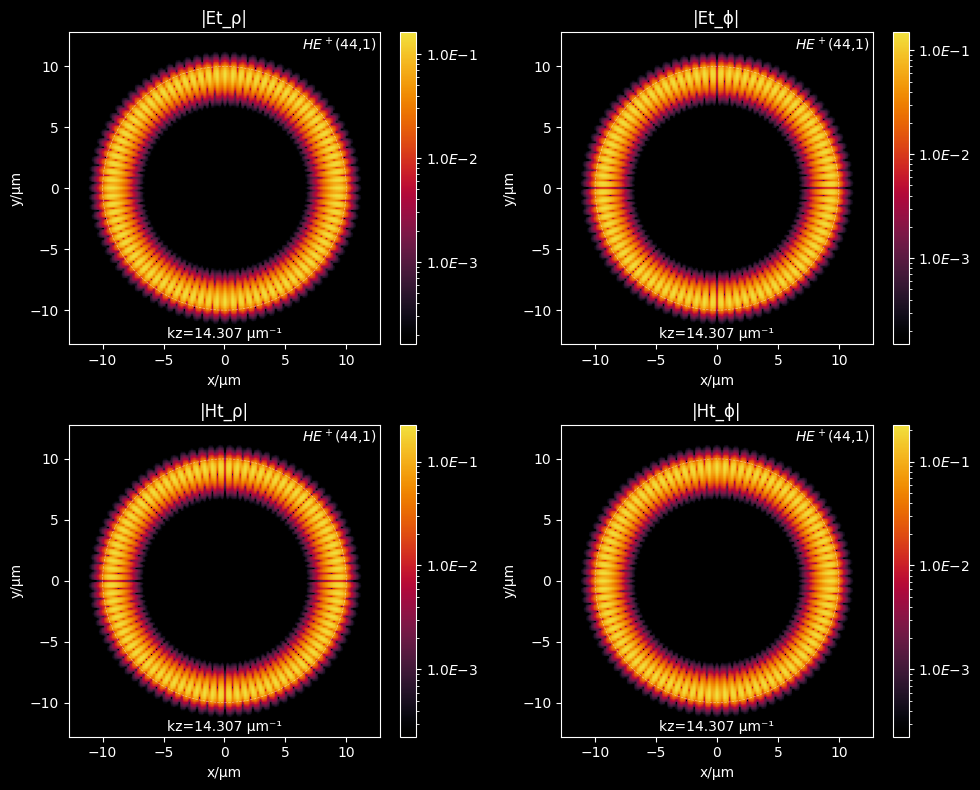

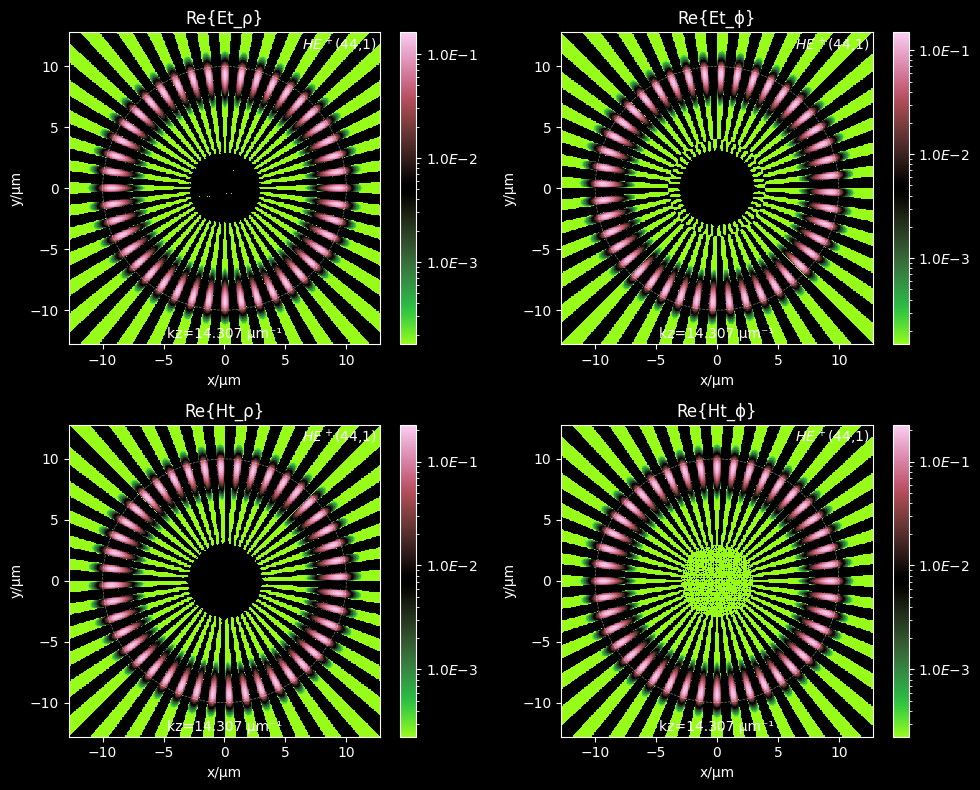

In [147]:
# Plotting a single mode
# In a panel of four figures:
# plot the magnitudes of the cylindrical components of the E
# and same for the H field.
# In another panel of four figures:
# plot the real and imaginary parts of the cylindrical components of E and H.

def fmt(x, pos):
    if x == 0:
        return '0'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} E{{{}}}$'.format(a, b)

plt.style.use('dark_background')
component_index = {"Et_ρ":(0,0), "Et_ϕ":(0,1), "Ht_ρ":(1,0), "Ht_ϕ":(1,1)}
index = -10
extent  = [-b,b,-b,b]
for fun_picker in [np.abs, np.real]:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    if fun_picker in [np.real, np.imag]:
        cmap = cm.watermelon
        if fun_picker == np.real:
            title_format = 'Re{%s}'
        else:
            title_format = 'Im{%s}'
    else:
        cmap = cm.ember
        title_format = '|%s|'
    for component, ci in component_index.items():
        field   = fiber_sol['eigenbasis'][index, ci[0], ci[1], :, :]
        field   = fun_picker(field)
        if np.max(field) == 0 and fun_picker != np.abs:
            if fun_picker == np.real:
                fun_picker = np.imag
                title_format = 'Im{%s}'
            else:
                fun_picker = np.real
                title_format = 'Re{%s}'
            field   = eigenbasis[index, ci[0], ci[1], :, :]
            field   = fun_picker(field)
        axis = axes[ci[0], ci[1]]
        if fun_picker in [np.real, np.imag]:
            themax = np.max(field)
            vmax = themax
            vmin = -themax
        else:
            vmax = np.max(field)
            vmin = 0
        iplot = axis.imshow(field, 
                # vmin=vmin,
                # vmax=vmax,
                norm=LogNorm(vmin=vmax*1e-3, vmax=vmax),
                extent=extent,
                cmap=cmap)
        axis.set_xlabel('x/µm')
        axis.set_ylabel('y/µm')
        axis.set_title(title_format % component)
        axis.text(0.99, 0.99, annotations[index][0], color='w', transform=axis.transAxes, horizontalalignment='right', verticalalignment='top')
        axis.text(0.5, 0.01, annotations[index][1], color='w', transform=axis.transAxes, horizontalalignment='center', verticalalignment='bottom')
        circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
        axis.add_patch(circle)
        divider = make_axes_locatable(axis)
        cax = divider.append_axes("right", size="5%", pad=0.2)
        plt.colorbar(iplot, cax=cax, format=ticker.FuncFormatter(fmt))
    plt.tight_layout()
    plt.show()

In [139]:
# same a above but
# plot for at most 10 randomly picked modes
save_em = True
totalModes = fiber_sol['totalModes']
eigenbasis = fiber_sol['eigenbasis']
plt.style.use('dark_background')
component_index = {"Et_ρ":(0,0), "Et_ϕ":(0,1), "Ht_ρ":(1,0), "Ht_ϕ":(1,1)}
extent  = [-b,b,-b,b]
imout = 10
counter = 0
justafew = True
for index in tqdm(range(totalModes)):
    if justafew:
        if np.random.random() < imout/totalModes:
            counter += 1
        else:
            continue
        if counter >= imout:
            break
    for fun_picker in [np.abs, np.real]:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
        if fun_picker in [np.real, np.imag]:
            cmap = cm.watermelon
            if fun_picker == np.real:
                title_format = 'Re{%s}'
            else:
                title_format = 'Im{%s}'
        else:
            cmap = cm.ember
            title_format = '|%s|'
        for component, ci in component_index.items():
            field   = eigenbasis[index, ci[0], ci[1], :, :]
            field   = fun_picker(field)
            if np.max(field) == 0 and fun_picker != np.abs:
                if fun_picker == np.real:
                    fun_picker = np.imag
                    title_format = 'Im{%s}'
                else:
                    fun_picker = np.real
                    title_format = 'Re{%s}'
                field   = fiber_sol['eigenbasis'][index, ci[0], ci[1], :, :]
                field   = fun_picker(field)
            axis = axes[ci[0], ci[1]]
            if fun_picker in [np.real, np.imag]:
                themax = np.max(field)
                vmax = themax
                vmin = -themax
            else:
                vmax = np.max(field)
                vmin = 0
            iplot = axis.imshow(field, 
                    vmin=vmin,
                    vmax=vmax,
                    extent=extent,
                    cmap=cmap)
            axis.set_xlabel('x/µm')
            axis.set_ylabel('y/µm')
            axis.set_title(title_format % component)
            axis.text(0.99, 0.99, annotations[index][0], color='w', transform=axis.transAxes, horizontalalignment='right', verticalalignment='top')
            axis.text(0.5, 0.01, annotations[index][1], color='w', transform=axis.transAxes, horizontalalignment='center', verticalalignment='bottom')
            circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
            axis.add_patch(circle)
            divider = make_axes_locatable(axis)
            cax = divider.append_axes("right", size="5%", pad=0.2)
            plt.colorbar(iplot, cax=cax, format=ticker.FuncFormatter(fmt))
        plt.tight_layout()
        if fun_picker in [np.real, np.imag]:
            fname = './FG050LGA/reim/mode-%d.png' % index
        else:
            fname = './FG050LGA/abs/mode-%d.png' % index
        if save_em:
            plt.savefig(fname)
        else:
            plt.show()
        plt.close()


  0%|          | 0/1388 [00:00<?, ?it/s]

## ## Checking boundary conditions

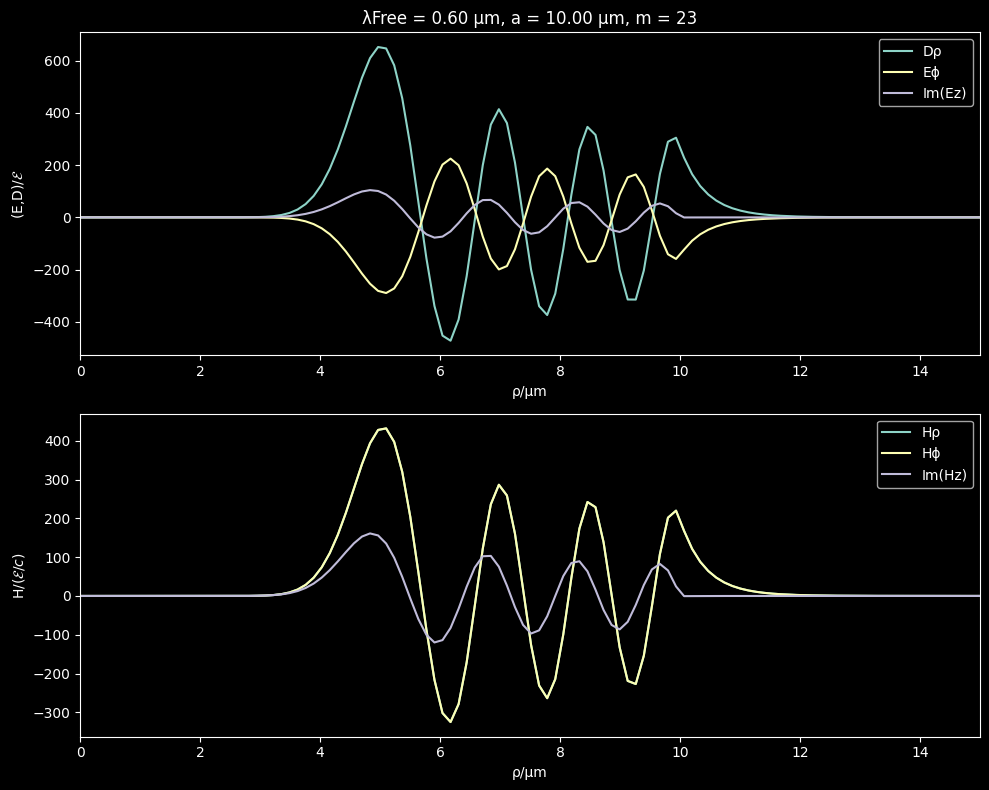

In [97]:
a = fiber_spec['coreRadius']
kFree = fiber_spec['kFree']
λFree = 2*np.pi/kFree
fieldType = 'HE'
m = max(fiber_sol['HEkz'].keys()) // 2
kz = fiber_sol[fieldType + 'kz'][m][-1]
nCladding = fiber_spec['nCladding']
nCore = fiber_spec['nCore']
Efuncs, Hfuncs = ws.fieldGenerator(a=a, kFree=kFree, kz=kz, m=m, nCladding=nCladding, nCore=nCore, fieldType=fieldType)
(ECoreρ, ECoreϕ, ECorez, ECladdingρ, ECladdingϕ, ECladdingz) = Efuncs
(HCoreρ, HCoreϕ, HCorez, HCladdingρ, HCladdingϕ, HCladdingz) = Hfuncs
def Efun(a):
    def fun(ρ):
        if ρ<a:
            return ECoreρ(ρ), ECoreϕ(ρ), ECorez(ρ)
        else:
            return ECladdingρ(ρ), ECladdingϕ(ρ), ECladdingz(ρ)
    return fun
def Hfun(a):
    def fun(ρ):
        if ρ<a:
            return HCoreρ(ρ), HCoreϕ(ρ), HCorez(ρ)
        else:
            return HCladdingρ(ρ), HCladdingϕ(ρ), HCladdingz(ρ)
    return fun

N = 150
dρ = a/N
ptitle = f'λFree = {λFree:.2f} μm, a = {a:.2f} μm, m = {m}'
ρrange = np.linspace(0,2*a,N)
electricFun = Efun(a)
electricFun = np.vectorize(electricFun)
magneticFun = Hfun(a)
magneticFun = np.vectorize(magneticFun)
Evals = electricFun(ρrange)
Hvals = magneticFun(ρrange)
refIndex = np.zeros(N)
refIndex[ρrange<a] = nCore
refIndex[ρrange>=a] = nCladding
permittivity = refIndex**2
fig, axes = plt.subplots(nrows=2, figsize=(10,8))
axes[0].plot(ρrange,Evals[0]*permittivity,label='Dρ')
axes[0].plot(ρrange,Evals[1],label='Eϕ')
axes[0].plot(ρrange,np.imag(Evals[2]),label='Im(Ez)')
axes[1].plot(ρrange,Hvals[0],label='Hρ')
axes[1].plot(ρrange,Hvals[1],label='Hϕ')
axes[1].plot(ρrange,np.imag(Hvals[2]),label='Im(Hz)')
for ax in axes:
    ax.set_xlim(0,1.5*a)
    ax.set_xlabel('ρ/μm')
    ax.legend()
axes[0].set_ylabel('(E,D)/$\mathcal{E}$')
axes[1].set_ylabel('H/($\mathcal{E}/c$)')
axes[0].set_title(ptitle)
plt.tight_layout()
plt.show()

## ## Checking orthonormality of the modal basis

In [99]:
# check to see if the resulting basis is orthonormal
dotProducts = []
dodDir = {}
for i in range(len(eigenbasis)):
    for j in range(len(eigenbasis)):
        if (j, i) in dodDir:
            dotProducts.append(dodDir[(j, i)])
            continue
        E_field = eigenbasis[i][0]
        H_field = eigenbasis[j][1]
        dotP = np.abs(ws.field_dot(E_field, H_field, Δs))
        dodDir[(i, j)] = dotP
        if i != j and dotP > 0.5:
            1/0
        dotProducts.append(dotP)
dotProducts = np.array(dotProducts)
dotProducts = dotProducts.reshape(len(eigenbasis), len(eigenbasis))

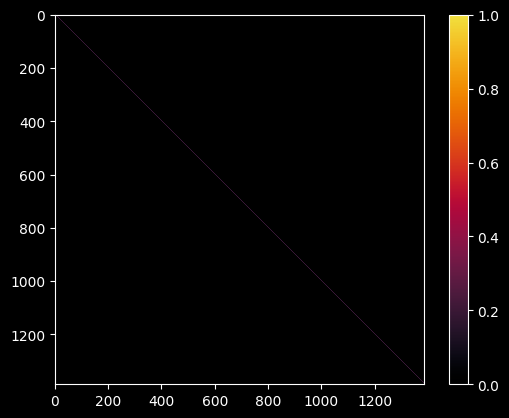

In [101]:
plt.figure()
plt.imshow(dotProducts, vmin=0, vmax=1, cmap=cm.ember)
plt.colorbar()
plt.show()

## ## Power within core

In [25]:
eigenbasis = fiber_sol['eigenbasis']
wavenums = fiber_sol['eigenbasis_nums']

In [26]:
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']

In [37]:
kzs = np.array(list(map(lambda x: x[-3], wavenums)))

In [15]:
# check to see if the resulting basis is orthonormal
corePowers = []
dodDir = {}
for i in range(len(eigenbasis)):
    E_field = eigenbasis[i][0]
    H_field = eigenbasis[i][1]
    dotP = np.abs(ws.field_dot(E_field, H_field, Δs, mask=crossMask))
    corePowers.append(dotP)
corePowers = np.array(corePowers)

In [38]:
np.argmin(kzs)

500

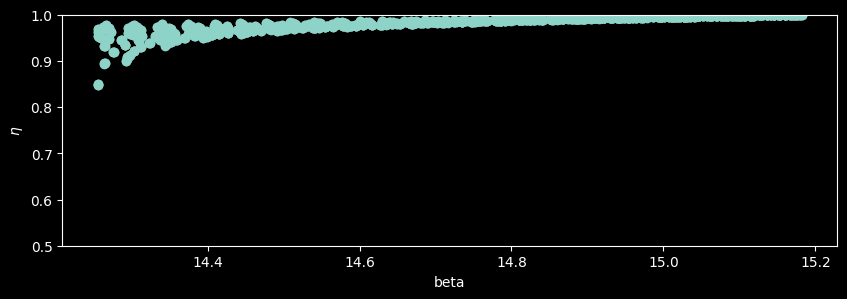

In [39]:
plt.figure(figsize=(10,3))
plt.plot(kzs, corePowers, 'o')
plt.xlabel('beta')
plt.ylabel('$\eta$')
# plt.xlim(0, len(corePowers)-1)
plt.ylim(0.5,1.)
plt.show()

In [44]:
a = fiber_spec['coreRadius']
kFree = fiber_spec['kFree']
λFree = 2*np.pi/kFree
nCladding = fiber_spec['nCladding']
nCore = fiber_spec['nCore']

In [46]:
allnums = []
for modetype in ['TE', 'TM', 'HE']:
    allkzs = fiber_sol[modetype + 'kz']
    for m, kzs in allkzs.items():
        for kz in kzs:
            wnums = (modetype, m, kz)
            allnums.append(wnums)

In [87]:
(modetype, m, kz) = sorted(allnums, key=lambda x: x[-1])[0]

In [88]:
(Efuncs, Hfuncs) = ws.fieldGenerator(a, kFree, kz, m, nCladding, nCore, modetype)

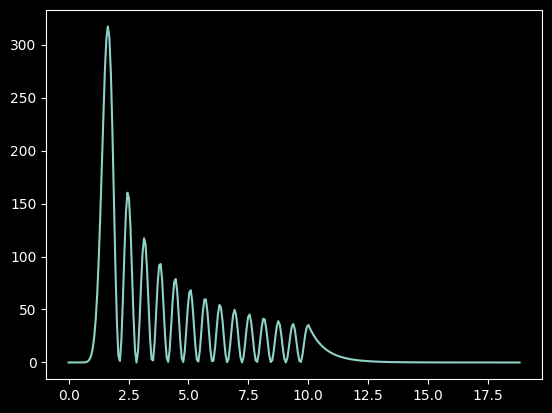

In [101]:
ρrange = np.linspace(0, a + 20*λFree/nCladding, 300)
fluxCore = Efuncs[0](ρrange) * np.conjugate(Hfuncs[1](ρrange)) - Efuncs[1](ρrange) * np.conjugate(Hfuncs[0](ρrange))
fluxCladding = Efuncs[3](ρrange) * np.conjugate(Hfuncs[4](ρrange)) - Efuncs[4](ρrange) * np.conjugate(Hfuncs[3](ρrange))
flux = fluxCore
flux[ρrange>a] = fluxCladding[ρrange>a]
plt.figure()
plt.plot(ρrange, flux, label='real')
plt.show()

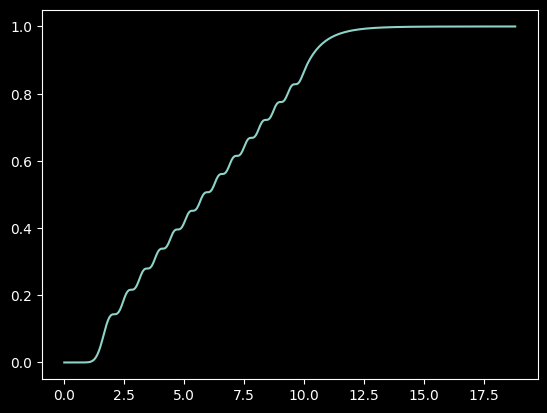

In [102]:
integrand = flux * ρrange
total = np.sum(integrand)
insideEnergy =  np.cumsum(integrand)/total
plt.figure()
plt.plot(ρrange,insideEnergy)
plt.show()

## ## Comparison against published data

In [40]:
snyder12p4dframes = pd.read_excel('./data/snyder12p4.xls', sheet_name=None)
snyder12p4 = {k: v.to_numpy() for k, v in snyder12p4dframes.items()}

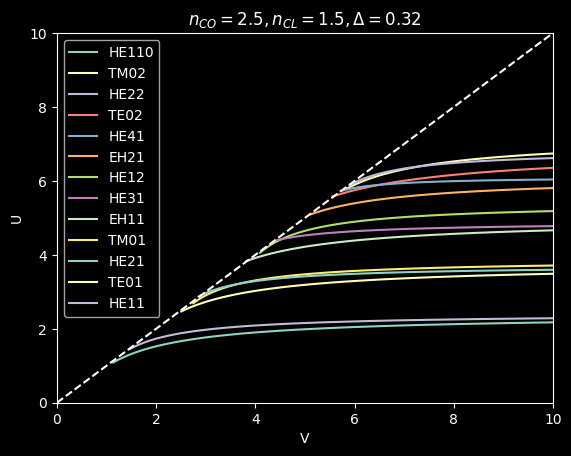

In [41]:
plt.figure()
for k, v in snyder12p4.items():
    plt.plot(v[:,0], v[:,1], label=k)
plt.plot([0,10],[0,10],'w--')
plt.legend()
plt.xlabel('V')
plt.ylabel('U')
plt.title('$n_{CO}=2.5, n_{CL}=1.5, \Delta = 0.32$')
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

In [42]:
nCore = 2.5
nCladding = 1.5
λFree = 2 * np.pi
Vsnys = np.linspace(2, 10, 20)
compareTE = []
compareTM = []
compareHE = []
allCompared = []
for Vsny in Vsnys:
    a = Vsny/np.sqrt(nCore**2-nCladding**2)
    k = 2 * np.pi / λFree
    U = a * (k**2 * nCore**2 - k)
    fiber_spec = {'nCore': nCore,
                'nCladding': nCladding,
                'λFree': λFree,
                'coreRadius': a}
    fiber_sol = ws.multisolver(fiber_spec, verbose=False)
    
    allkz = [list(fiber_sol['TEkz'].values())]
    allkz=sum(list(map(list,sum(allkz,[]))),[])
    allkz=np.array(sorted(allkz))
    Ws = a * np.sqrt(k * nCore**2 - allkz**2)
    Ws = np.array([[Vsny]*len(Ws), Ws])
    compareTE.append(Ws)
    allkz = [list(fiber_sol['TMkz'].values())]
    allkz=sum(list(map(list,sum(allkz,[]))),[])
    allkz=np.array(sorted(allkz))
    Ws = a * np.sqrt(k * nCore**2 - allkz**2)
    Ws = np.array([[Vsny]*len(Ws), Ws])
    compareTM.append(Ws)
    allkz = [list(fiber_sol['HEkz'].values())]
    allkz=sum(list(map(list,sum(allkz,[]))),[])
    allkz=np.array(sorted(allkz))
    Ws = a * np.sqrt(k * nCore**2 - allkz**2)
    Ws = np.array([[Vsny]*len(Ws), Ws])
    compareHE.append(Ws)
    allkz = [list(fiber_sol['TEkz'].values()),
             list(fiber_sol['TMkz'].values()),
             list(fiber_sol['HEkz'].values())]
    allkz=sum(list(map(list,sum(allkz,[]))),[])
    allkz=sorted(allkz)
    if len(allkz)>12:
        allkz=allkz[-12:]
    allkz=np.array(sorted(allkz))
    Ws = a * np.sqrt(k * nCore**2 - allkz**2)
    Ws = np.array([[Vsny]*len(Ws), Ws])
    allCompared.append(Ws)

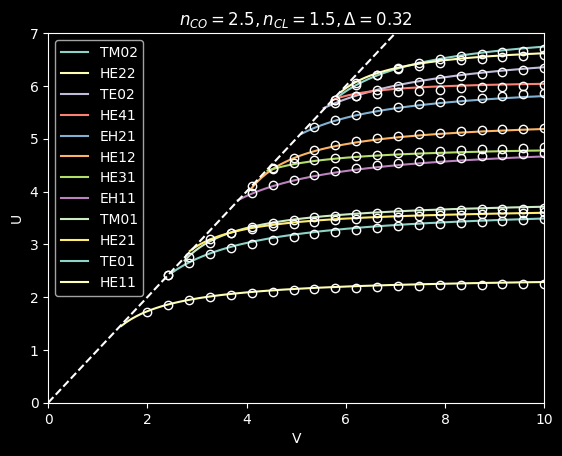

In [43]:
plt.figure()
for k, v in snyder12p4.items():
    if k == 'HE110':
        continue
    plt.plot(v[:,0], v[:,1], label=k)
plt.plot([0,10],[0,10],'w--')
# for vals in compareTM:
#     plt.plot(vals[0],vals[1],'rx')
# for vals in compareTE:
#     plt.plot(vals[0],vals[1],'wx')
# for vals in compareHE:
#     plt.plot(vals[0],vals[1],'gx')
for vals in allCompared:
    plt.plot(vals[0],vals[1],'wo', fillstyle='none')
plt.legend()
plt.xlabel('V')
plt.ylabel('U')
plt.title('$n_{CO}=2.5, n_{CL}=1.5, \Delta = 0.32$')
plt.xlim(0, 10)
plt.ylim(0,7)
plt.show()

Approx number of complex HE modes:  8
Approx number of TE modes:  3
Approx number of TM modes:  3
Approx number of total modes:  24
Approx Max n for HE modes:  4
Calculating TM(0,n) propagation constants ...
Calculating TE(0,n) propagation constants ...


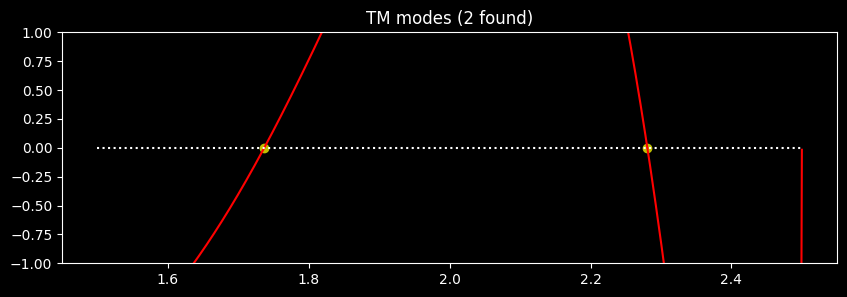

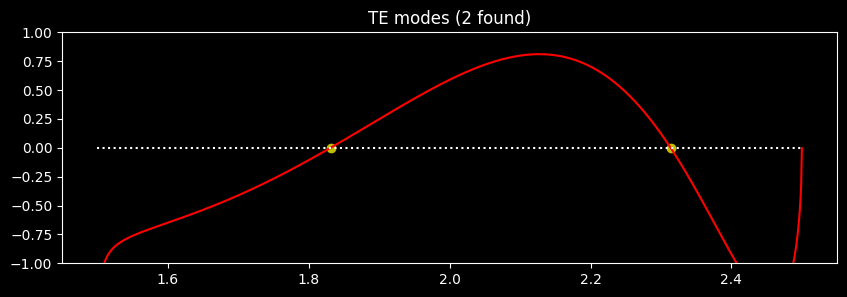

Calculating HE(m,n) propagation constants ...


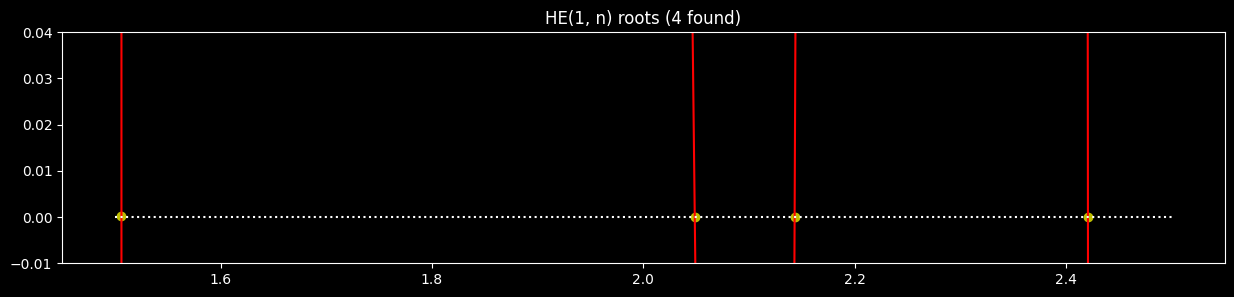

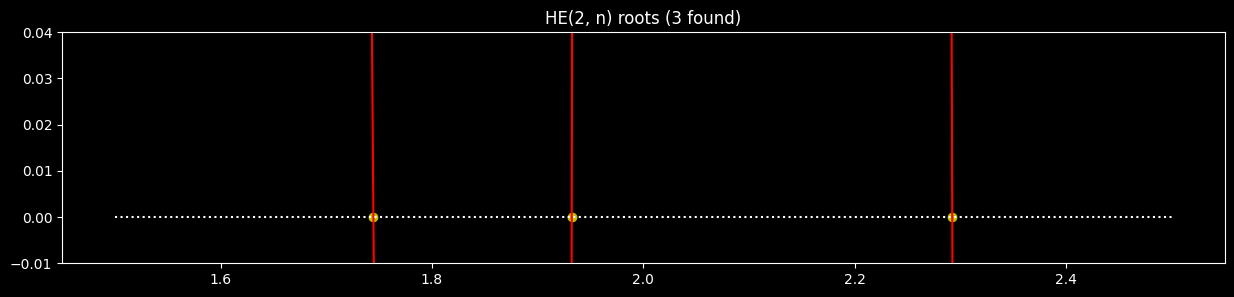

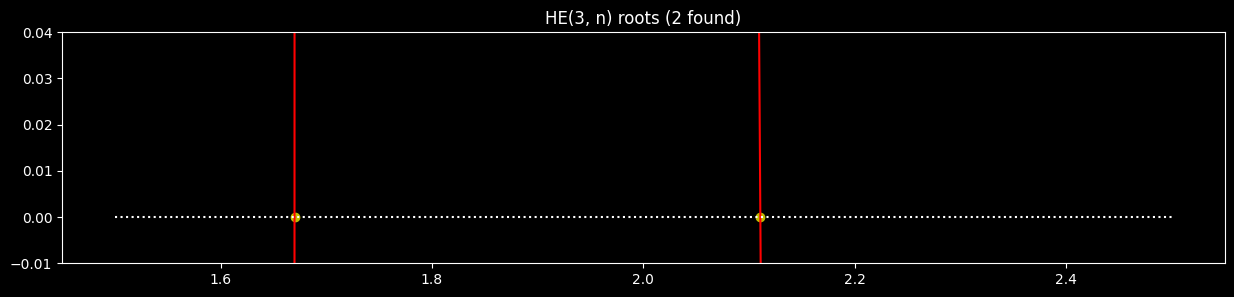

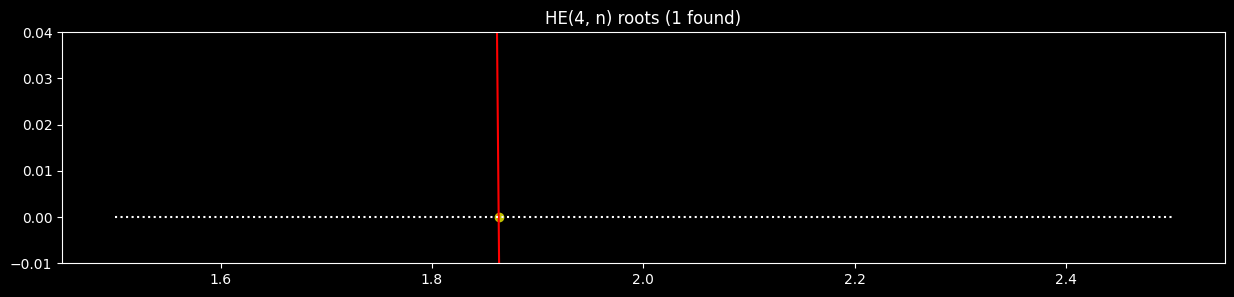

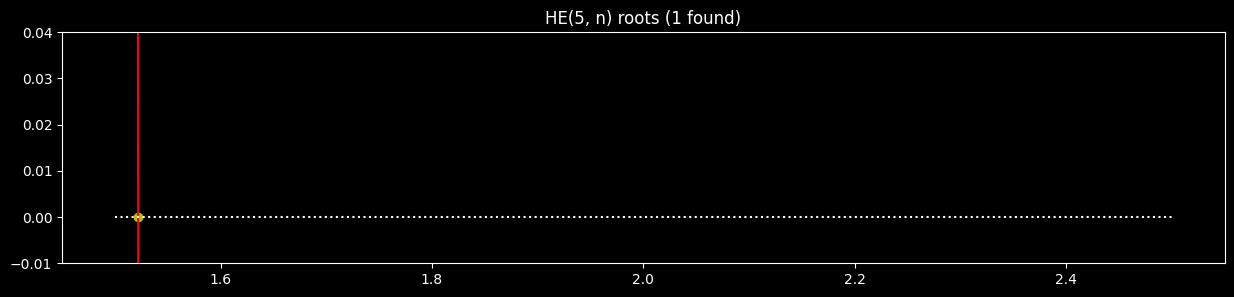

m=6
HE modes = 22
TE modes = 2
TM modes = 2
TOTAL modes = 26
FROM_Vnum = 24


In [27]:
Vsny = Vsnys[12]
a = Vsny/np.sqrt(nCore**2-nCladding**2)
k = 2 * np.pi / λFree
U = a * (k**2 * nCore**2 - k)
fiber_spec = {'nCore': nCore,
            'nCladding': nCladding,
            'λFree': λFree,
            'coreRadius': a}
fiber_sol = ws.multisolver(fiber_spec, verbose=True, drawPlots=True)

In [28]:
fiber_sol['HEkz']

{1: array([1.50618019, 2.04864905, 2.14314773, 2.42068463]),
 2: array([1.74456921, 1.93225059, 2.29230755]),
 3: array([1.66992085, 2.11070863]),
 4: array([1.86309439]),
 5: array([1.52195671])}

In [30]:
nCore,nCladding,a

(2.5, 1.5, 3.526315789473684)